In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2, os
import tensorflow as tf
from tensorflow.keras import  layers, models
from sklearn.model_selection import train_test_split

In [7]:
def set_seed(seed=2137):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()
DATA_PATH = 'data/landscape/'
IMG_DIM =(256,256)

In [3]:
def augment_data(img_l,img_ab):
    #img_l = tf.image.random_brightness(img_l, max_delta=0.2)  
    img_l = tf.image.random_contrast(img_l, lower=0.8, upper=1.2)
    image=tf.concat([img_l,img_ab],axis=-1)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    
    image_l = image[..., :1]
    image_ab = image[..., 1:]

    return image_l, image_ab
def create_dataset(X,y,batch_size=32, augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(1000)
    if augmentation:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
    

In [4]:
def display_colorized_images(model, X_test, y_test=None, num_images=10):
    indices = np.random.choice(len(X_test), num_images, replace=False)
    plt.figure(figsize=(15, num_images * 3)) 
    
    for i, idx in enumerate(indices):
        img_l = X_test[idx][np.newaxis, ...]  
        img_l_display = img_l[0, ..., 0] * 255  
        
        
        pred_ab = model.predict(img_l, verbose=0)[0] 
        pred_ab = (pred_ab + 1) * 128 
        
        
        img_lab = np.zeros((224, 224, 3), dtype=np.float32)
        img_lab[:, :, 0] = img_l_display
        img_lab[:, :, 1:] = pred_ab
        
        
        img_rgb = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
        
        
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.title("Grayscale (L)")
        plt.imshow(img_l_display, cmap='gray')
        plt.axis('off')
        
        
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.title("Predicted Color")
        plt.imshow(img_rgb)
        plt.axis('off')
        
        
        if y_test is not None:
            img_ab_true = (y_test[idx] + 1) * 128  
            img_lab_true = np.zeros((224, 224, 3), dtype=np.float32)
            img_lab_true[:, :, 0] = img_l_display
            img_lab_true[:, :, 1:] = img_ab_true
            img_rgb_true = cv2.cvtColor(img_lab_true.astype(np.uint8), cv2.COLOR_LAB2RGB)
            
            plt.subplot(num_images, 3, i * 3 + 3)
            plt.title("Ground Truth")
            plt.imshow(img_rgb_true)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
X = []
y = []
for imgdir in os.listdir(DATA_PATH):
    img = cv2.imread(DATA_PATH + imgdir)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_lab_rs = cv2.resize(img_lab,IMG_DIM)
    img_l = img_lab_rs[:,:,0]
    img_ab = img_lab_rs[:,:,1:] 
    X.append(img_l[...,np.newaxis]) # [...,np.newaxis] sprawia że mamy tensor (128,128,1) a nie (128,128)
    y.append(img_ab)
    
X = np.array(X)
y = np.array(y)
X = X /255
y = y / 128 -1 


In [6]:
X_train,X_test, y_train,y_test = train_test_split(X, y,test_size=0.2)
input_shape = X_train[0].shape
print(input_shape)

(224, 224, 1)


In [8]:
input_layer = layers.Input(shape=input_shape)


conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(input_layer)
conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv1)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(pool1)
conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv2)
pool2 = layers.MaxPooling2D((2, 2))(conv2)


conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(pool2)
conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv3)


up1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
concat1 = layers.Concatenate()([up1, conv2])
conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(concat1)
conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv4)

up2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
concat2 = layers.Concatenate()([up2, conv1])
conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(concat2)
conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform')(conv5)

output = layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(conv5)

model = tf.keras.Model(inputs=input_layer, outputs=output)

In [9]:

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 224, 224, 64)      │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 224, 224, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 112, 112, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 112, 112, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 56, 56, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 56, 56, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 112, 112, 128)     │         131,200 │ conv2d_5[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 112, 112, 256)     │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 112, 112, 128)     │         295,040 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 112, 112, 128)     │         147,584 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 224, 224, 64)      │          32,832 │ conv2d_7[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 224, 224, 128)     │               0 │ conv2d_transpose_1[0][0],  │
│                               │                           │               

 Total params: 1,862,786 (7.11 MB)

 Trainable params: 1,862,786 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

In [11]:
train_ds = create_dataset(X_train, y_train, batch_size=32, augmentation=True)
val_ds = create_dataset(X_test, y_test, batch_size=32, augmentation=False)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=callbacks,
                   verbose=1)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 908s 8s/step - loss: 0.0783 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 916s 8s/step - loss: 0.0159 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 910s 8s/step - loss: 0.0150 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 917s 9s/step - loss: 0.0143 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 919s 9s/step - loss: 0.0139 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 924s 9s/step - loss: 0.0138 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 933s 9s/step - loss: 0.0133 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 923s 9s/step - loss: 0.0133 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 919s 9s/step - loss: 0.0133 - val_loss: 0.0138 - learning_rate: 0.0010
E

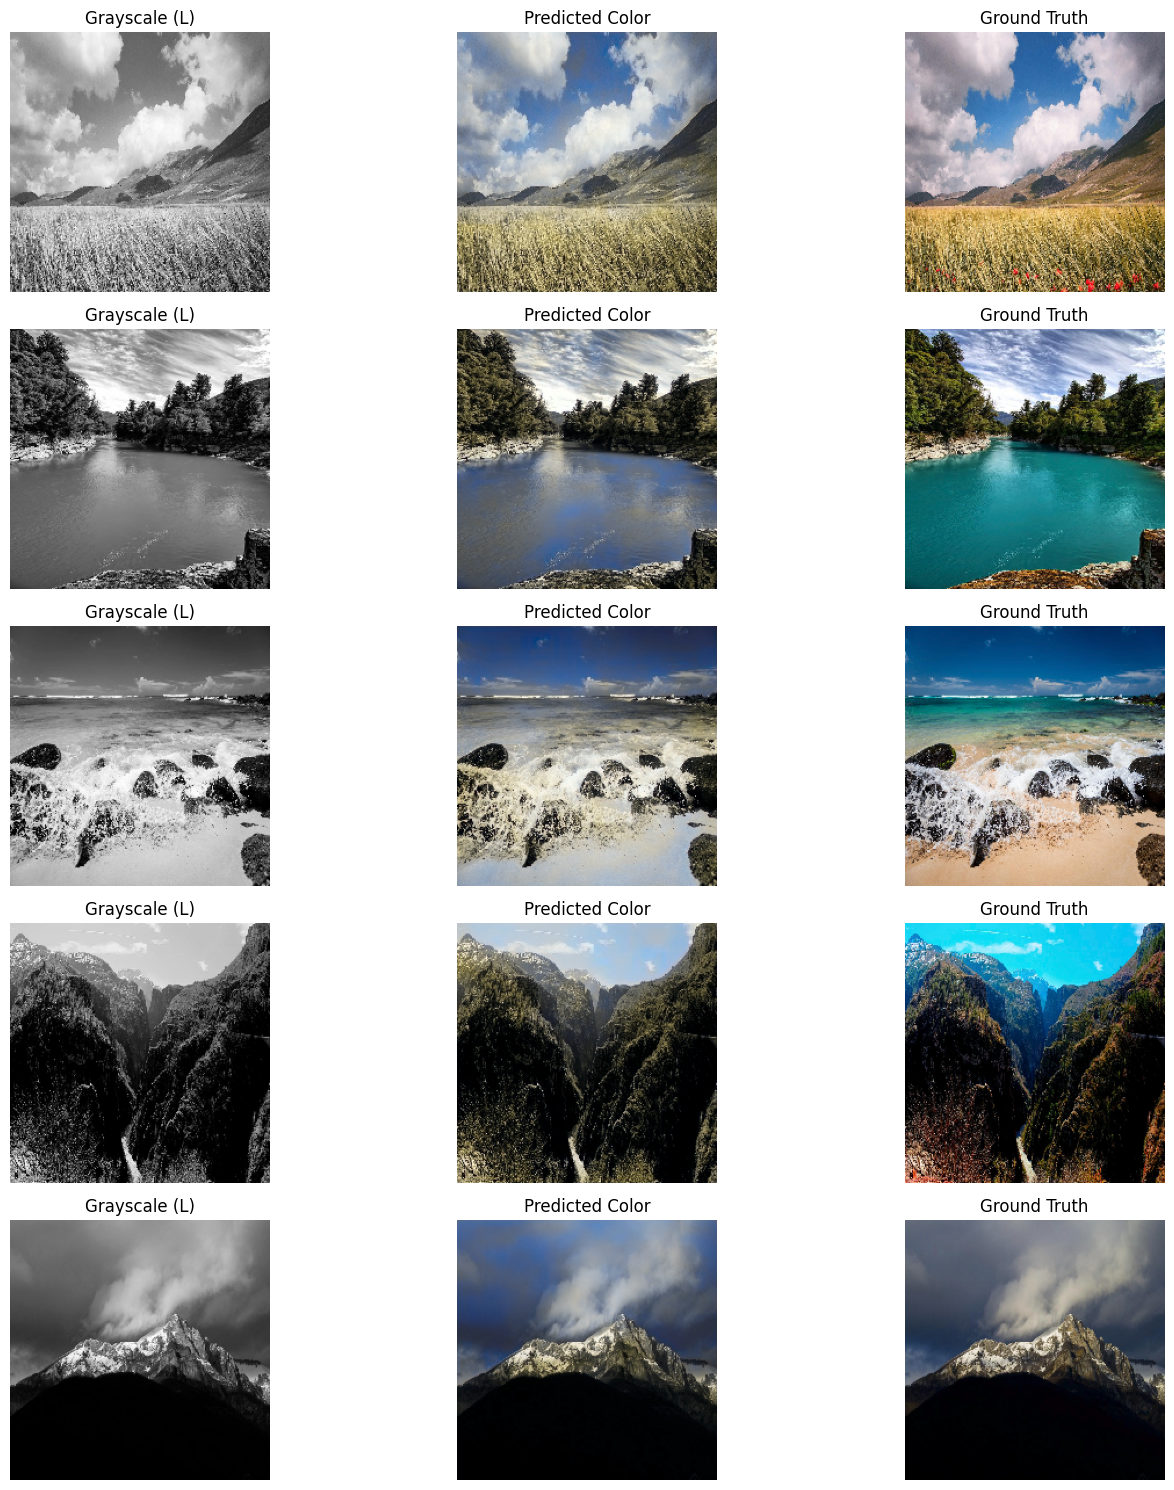

In [16]:
display_colorized_images(model, X_test, y_test, num_images=5)

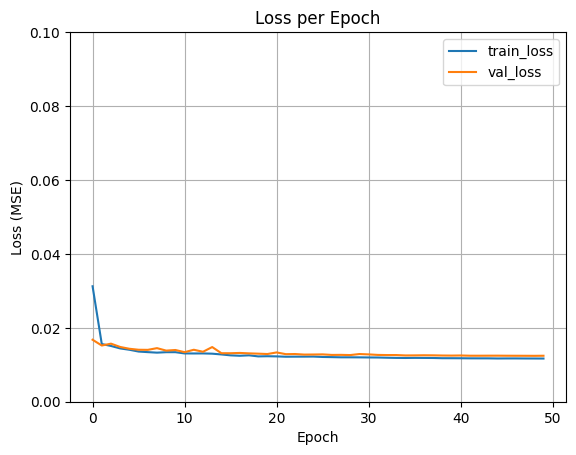

In [22]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss ')
plt.ylim([0, 0.1])
plt.legend(loc='upper right')
plt.title('Strata na Epoch')
plt.grid(True)
plt.show()


27/27 - 63s - 2s/step - loss: 0.0124
Dokładność dla zbioru testowego wynosi1.24
